In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
import os
from utils.utils import EDAHelperFunctions
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
helpers = EDAHelperFunctions()

In [12]:
country_name = 'croatia'
lhc_sampled_data_path = 'lhs_sampled_data'
features_csv_path = os.path.join(lhc_sampled_data_path, f'lhs_sampled_{country_name}_features.csv')
targets_csv_path = os.path.join(lhc_sampled_data_path, f'lhs_sampled_{country_name}_targets.csv')

## Let's start by cleaning the features data.

In [14]:
df_features = pd.read_csv(features_csv_path)
print('Features df initial shape: ', df_features.shape)
df_features.head()

Features df initial shape:  (495, 2035)


,id,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,avgmass_lvst_animal_goats_kg,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,1,98.965225,2021.126726,22.460987,11661.439699,75.782750,686.281369,500.905413,0.630586,14.434674,...,0.000003,0.0,35.247442,0.000081,0.0,0.457732,0.718314,0.0,1.506450,0.0
1,2,82.018999,649.762185,1.138680,12096.425758,110.485744,666.956416,360.247505,0.655126,34.567387,...,0.000002,0.0,8.277155,0.000021,0.0,1.346545,0.031895,0.0,0.017428,0.0
2,3,132.183250,499.860530,34.031414,11235.136283,34.204852,680.657825,150.651424,0.163753,30.652506,...,0.000008,0.0,33.966138,0.000083,-0.0,0.234139,1.718756,0.0,2.591001,0.0
3,4,20.518279,2656.278580,23.004404,3246.686810,418.601538,36.605498,587.291297,0.693318,1.396175,...,0.000006,0.0,9.116589,0.000033,0.0,0.728750,1.016315,0.0,2.140213,0.0
4,5,122.144099,2622.770980,48.459623,2369.915044,65.162086,160.283186,562.994950,1.608947,29.437398,...,0.000007,0.0,33.545865,0.000082,0.0,1.679300,0.869083,0.0,0.478881,0.0


In [16]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Columns: 2035 entries, id to nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
dtypes: float64(2034), int64(1)
memory usage: 7.7 MB


### Check NaNs

In [17]:
# Check for cols with null values
null_columns = helpers.check_null_values(df_features)

No null values found


In [19]:
# Double checking
df_features[null_columns].head()

""
0
1
2
3
4


In [20]:
# For now we drop if there is any NaN. It seems our attributes do not have NaNs so this is just for safety
df_features.dropna(axis=0, inplace=True)
print('Attributes df shape after using dropna: ', df_features.shape)

Attributes df shape after using dropna:  (495, 2035)


In [21]:
# Double check
helpers.check_null_values(df_features)

No null values found


[]

### Check cols that have the same value repeated

- If they are all 0 they can be dropped.
- If they have the same number they will not contribute to the variation we need.

TODO: Check the cols with the same number because they same to be important even though they have the repeated value. 

In [27]:
# Check for columns that have the same value in all rows
cols_with_repeated_zeros, cols_with_repeated_non_zeros = helpers.check_cols_with_same_val(df_features)

Amount of cols with repeated value zero:  544
Amount of cols with repeated value not zero:  18


In [28]:
cols_with_repeated_non_zeros

['frac_agrc_bevs_and_spices_cl1_temperate',
 'frac_agrc_cereals_cl1_temperate',
 'frac_agrc_fibers_cl1_temperate',
 'frac_agrc_fruits_cl1_temperate',
 'frac_agrc_herbs_and_other_perennial_crops_cl1_temperate',
 'frac_agrc_initial_yield_feed_cereals',
 'frac_agrc_nuts_cl1_temperate',
 'frac_agrc_other_annual_cl1_temperate',
 'frac_agrc_other_woody_perennial_cl1_temperate',
 'frac_agrc_pulses_cl1_temperate',
 'frac_agrc_rice_cl1_temperate',
 'frac_agrc_sugar_cane_cl1_temperate',
 'frac_agrc_tubers_cl1_temperate',
 'frac_agrc_vegetables_and_vines_cl1_temperate',
 'frac_lndu_grasslands_cl1_temperate',
 'frac_trns_fuelmix_aviation_kerosene',
 'frac_trns_fuelmix_rail_freight_diesel',
 'frac_trns_fuelmix_water_borne_diesel']

In [29]:
cols_with_repeated_zeros

['consumpinit_inen_energy_tj_per_tonne_production_wood',
 'consumpinit_scoe_tj_per_mmmgdp_other_se_elec_appliances',
 'consumpinit_scoe_tj_per_mmmgdp_other_se_heat_energy',
 'ef_fgtv_production_fugitive_tonne_ch4_per_m3_fuel_coal',
 'ef_fgtv_production_fugitive_tonne_co2_per_m3_fuel_coal',
 'ef_fgtv_production_venting_tonne_n2o_per_m3_fuel_oil',
 'ef_fgtv_transmission_tonne_n2o_per_m3_fuel_oil',
 'ef_ippu_tonne_c2f6_per_mmm_gdp_product_use_ods_other',
 'ef_ippu_tonne_c2f6_per_tonne_production_chemicals',
 'ef_ippu_tonne_c2f6_per_tonne_production_electronics',
 'ef_ippu_tonne_c2f6_per_tonne_production_metals',
 'ef_ippu_tonne_c2h3f3_per_tonne_production_chemicals',
 'ef_ippu_tonne_c2hf5_per_tonne_production_chemicals',
 'ef_ippu_tonne_c3f8_per_tonne_production_chemicals',
 'ef_ippu_tonne_c3f8_per_tonne_production_electronics',
 'ef_ippu_tonne_c3h2f6_per_mmm_gdp_product_use_ods_other',
 'ef_ippu_tonne_c3h2f6_per_mmm_gdp_product_use_ods_refrigeration',
 'ef_ippu_tonne_c3h3f5_per_mmm_gdp_p

In [32]:
df_features[cols_with_repeated_non_zeros]

,frac_agrc_bevs_and_spices_cl1_temperate,frac_agrc_cereals_cl1_temperate,frac_agrc_fibers_cl1_temperate,frac_agrc_fruits_cl1_temperate,frac_agrc_herbs_and_other_perennial_crops_cl1_temperate,frac_agrc_initial_yield_feed_cereals,frac_agrc_nuts_cl1_temperate,frac_agrc_other_annual_cl1_temperate,frac_agrc_other_woody_perennial_cl1_temperate,frac_agrc_pulses_cl1_temperate,frac_agrc_rice_cl1_temperate,frac_agrc_sugar_cane_cl1_temperate,frac_agrc_tubers_cl1_temperate,frac_agrc_vegetables_and_vines_cl1_temperate,frac_lndu_grasslands_cl1_temperate,frac_trns_fuelmix_aviation_kerosene,frac_trns_fuelmix_rail_freight_diesel,frac_trns_fuelmix_water_borne_diesel
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
491,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
492,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
493,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [33]:
# df_features.drop(columns=cols_with_repeated_values, inplace=True)
# print('Attributes df shape after dropping cols with all same values: ', df_attributes.shape)

In [34]:
# Double Check elimination
# cols_with_repeated_values = helpers.check_cols_with_same_val(df_attributes)

## Now let's move to analyze the target variables

In [35]:
df_target_vars = pd.read_csv(targets_csv_path)
df_target_vars.head()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_scoe,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trns,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
0,5.499280,0.0,38.249259,0.682673,5.212440,8.504367,9.813936,0.307097,0.162482,1.410981,12.557206,5.669082,66.855435,0.222631,0.606705
1,60.955144,0.0,0.000000,3.448018,0.878337,6.931762,7.271046,0.834958,0.241898,1.689836,8.754976,9.074713,10.193413,0.479124,-0.361258
2,2.161327,0.0,4.941868,0.988957,7.023753,1.492416,8.016953,0.904021,0.293937,2.713634,10.861261,3.089631,6.510802,0.405171,1.145891
3,18.538533,0.0,4.255659,0.195389,-3.453903,3.063859,5.896405,0.444213,1.270124,2.465650,13.206264,12.549674,6.759752,0.449830,0.730481
4,73.189860,0.0,23.886988,3.033221,5.011325,5.540381,29.738961,0.516231,0.857303,3.529391,5.355532,11.280944,8.997196,0.450191,1.183358


In [36]:
# Checkinng null values
helpers.check_null_values(df_target_vars)

No null values found


[]

In [37]:
helpers.check_cols_with_same_val(df_target_vars)

Amount of cols with repeated value zero:  1
Amount of cols with repeated value not zero:  0


(['emission_co2e_subsector_total_ccsq'], [])

In [38]:
helpers.get_lowest_variance_cols(df_target_vars)

1 out of 15 variables with variance < 0.01
['emission_co2e_subsector_total_ccsq']


['emission_co2e_subsector_total_ccsq']

## Addressing outliers
Using IQR to cap the outliers

In [53]:
df_target_vars.columns

Index(['emission_co2e_subsector_total_agrc',
       'emission_co2e_subsector_total_ccsq',
       'emission_co2e_subsector_total_entc',
       'emission_co2e_subsector_total_fgtv',
       'emission_co2e_subsector_total_frst',
       'emission_co2e_subsector_total_inen',
       'emission_co2e_subsector_total_ippu',
       'emission_co2e_subsector_total_lndu',
       'emission_co2e_subsector_total_lsmm',
       'emission_co2e_subsector_total_lvst',
       'emission_co2e_subsector_total_scoe',
       'emission_co2e_subsector_total_soil',
       'emission_co2e_subsector_total_trns',
       'emission_co2e_subsector_total_trww',
       'emission_co2e_subsector_total_waso'],
      dtype='object')

In [54]:
# Test target variable
test_target_var = 'emission_co2e_subsector_total_agrc'

In [55]:
df_features_capped = helpers.cap_outliers_iqr(df_features)

In [56]:
print(df_features.shape)
print(df_features_capped.shape)

(495, 2035)
(495, 2035)


In [57]:
df_target_vars_capped = helpers.cap_outliers_iqr(df_target_vars)

In [58]:
print(df_target_vars.shape)
print(df_target_vars_capped.shape)

(495, 15)
(495, 15)


<Axes: >

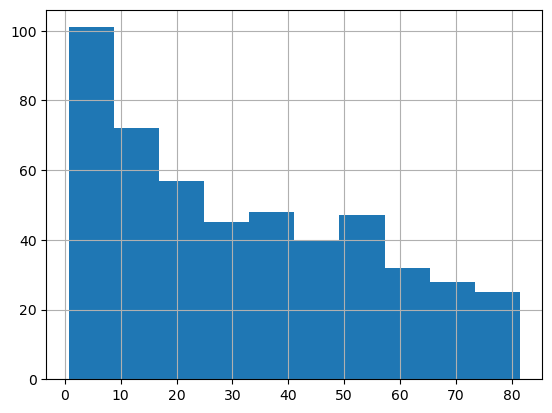

In [59]:
df_target_vars[test_target_var].hist()

<Axes: >

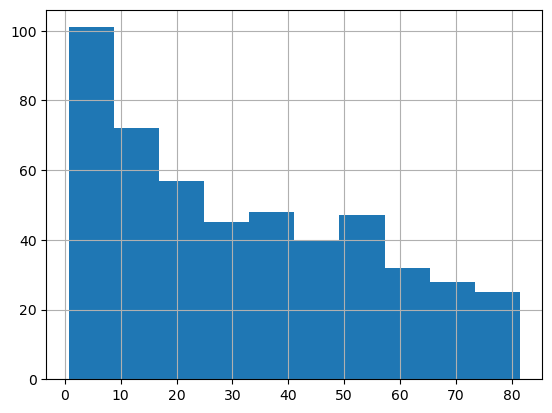

In [60]:
df_target_vars_capped[test_target_var].hist()

## ML Part

### Feature importance with RF (Testing with FGTV and without dealing with outliers)

In [61]:
X = df_features_capped.drop(columns=['id'])
y = df_target_vars_capped[test_target_var]

In [62]:
print(X.shape, y.shape)

(495, 2034) (495,)


 - Target variable stats:
   Var: 532.9579520198998, StDev: 23.085882093173304, IQR: 37.99426999474369


/home/tony-ubuntu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/tony-ubuntu/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Evaluation Metrics:
 - Mean Squared Error: 509.3743845094954
 - R2 Score: -0.03546356959984287


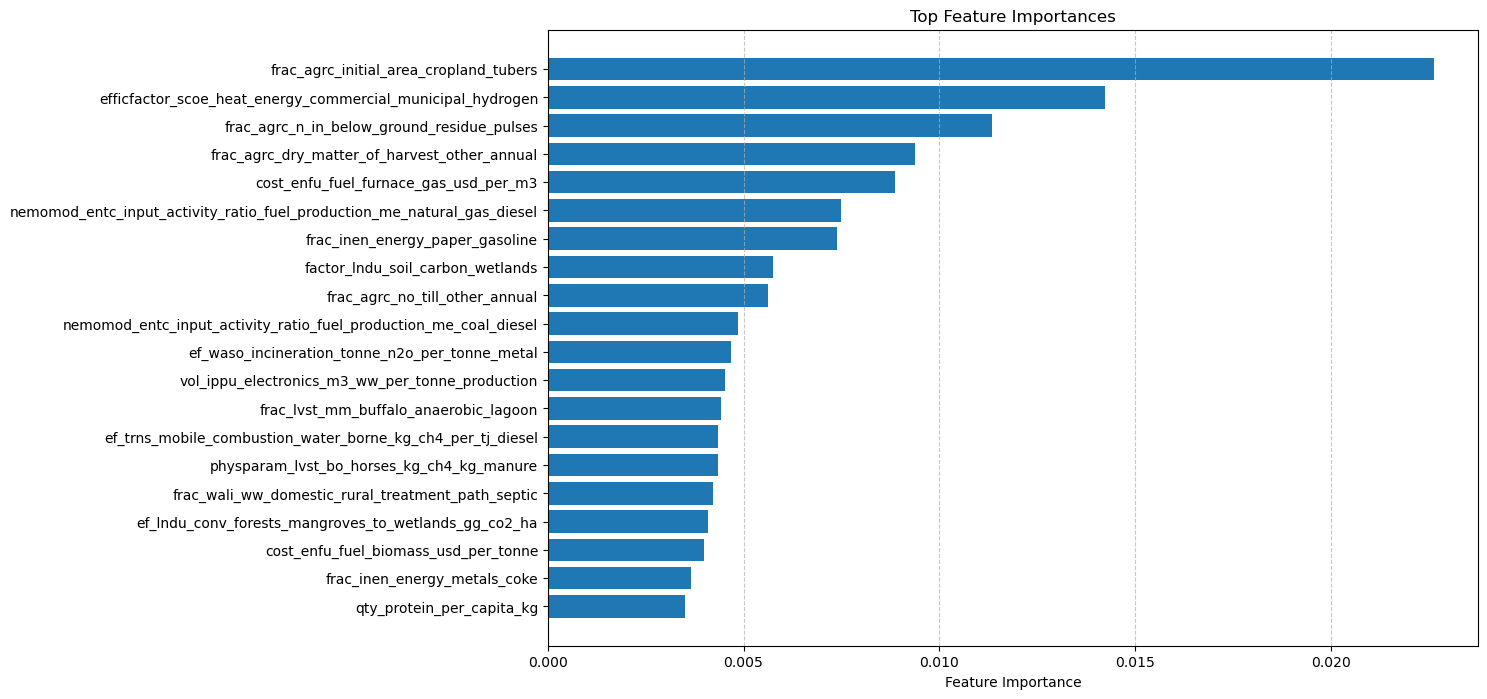

In [63]:
from utils.utils import FeatureImportanceRF

feature_importance_rd = FeatureImportanceRF(X, y)
results_dict = feature_importance_rd.run_feature_selector()

In [54]:
results_dict.keys()

dict_keys(['X_train_selected', 'X_test_selected', 'mse', 'r2', 'feature_importances'])

In [55]:
important_features = results_dict['feature_importances']
important_features.head()

,Feature,Importance
0,nemomod_entc_emissions_activity_ratio_fuel_pro...,0.026505
1,consumpinit_inen_energy_tj_per_tonne_productio...,0.022519
2,factor_lndu_soil_management_supremum_croplands,0.021422
3,factor_waso_waste_per_capita_scalar_plastic,0.019954
4,frac_agrc_crop_residues_burned,0.013815


In [56]:
ten_most_important_ft = important_features.Feature[:10]

In [57]:
X_important = X[ten_most_important_ft]
important_df = pd.concat([X_important, y], axis=1)
important_df.head()

,nemomod_entc_emissions_activity_ratio_fuel_production_fp_natural_gas_tonne_ch4_per_tj,consumpinit_inen_energy_tj_per_tonne_production_rubber_and_leather,factor_lndu_soil_management_supremum_croplands,factor_waso_waste_per_capita_scalar_plastic,frac_agrc_crop_residues_burned,elasticity_waso_msw_to_gdppc_metal,frac_agrc_crop_residues_removed,ef_trns_mobile_combustion_road_light_kg_n2o_per_tj_diesel,frac_inen_energy_lime_and_carbonite_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_waste,emission_co2e_subsector_total_scoe
0,0.000012,0.113591,0.878517,1.468704,0.588494,0.268575,0.411506,3.800479,0.068340,14.488051,12.557206
1,0.000035,0.083621,0.027900,1.893839,0.638245,0.249152,0.361755,4.127825,0.127038,14.566049,8.754976
2,0.000031,0.203952,0.362090,0.322310,0.597017,0.148923,0.402983,1.210300,0.102246,15.755915,10.861261
3,0.000064,0.058386,1.615028,0.168564,0.620976,0.212558,0.379024,6.211573,0.155402,4.012147,13.206264
4,0.000031,0.178048,1.327906,1.780451,0.640313,0.130849,0.359687,1.892351,0.096198,1.061779,5.355532


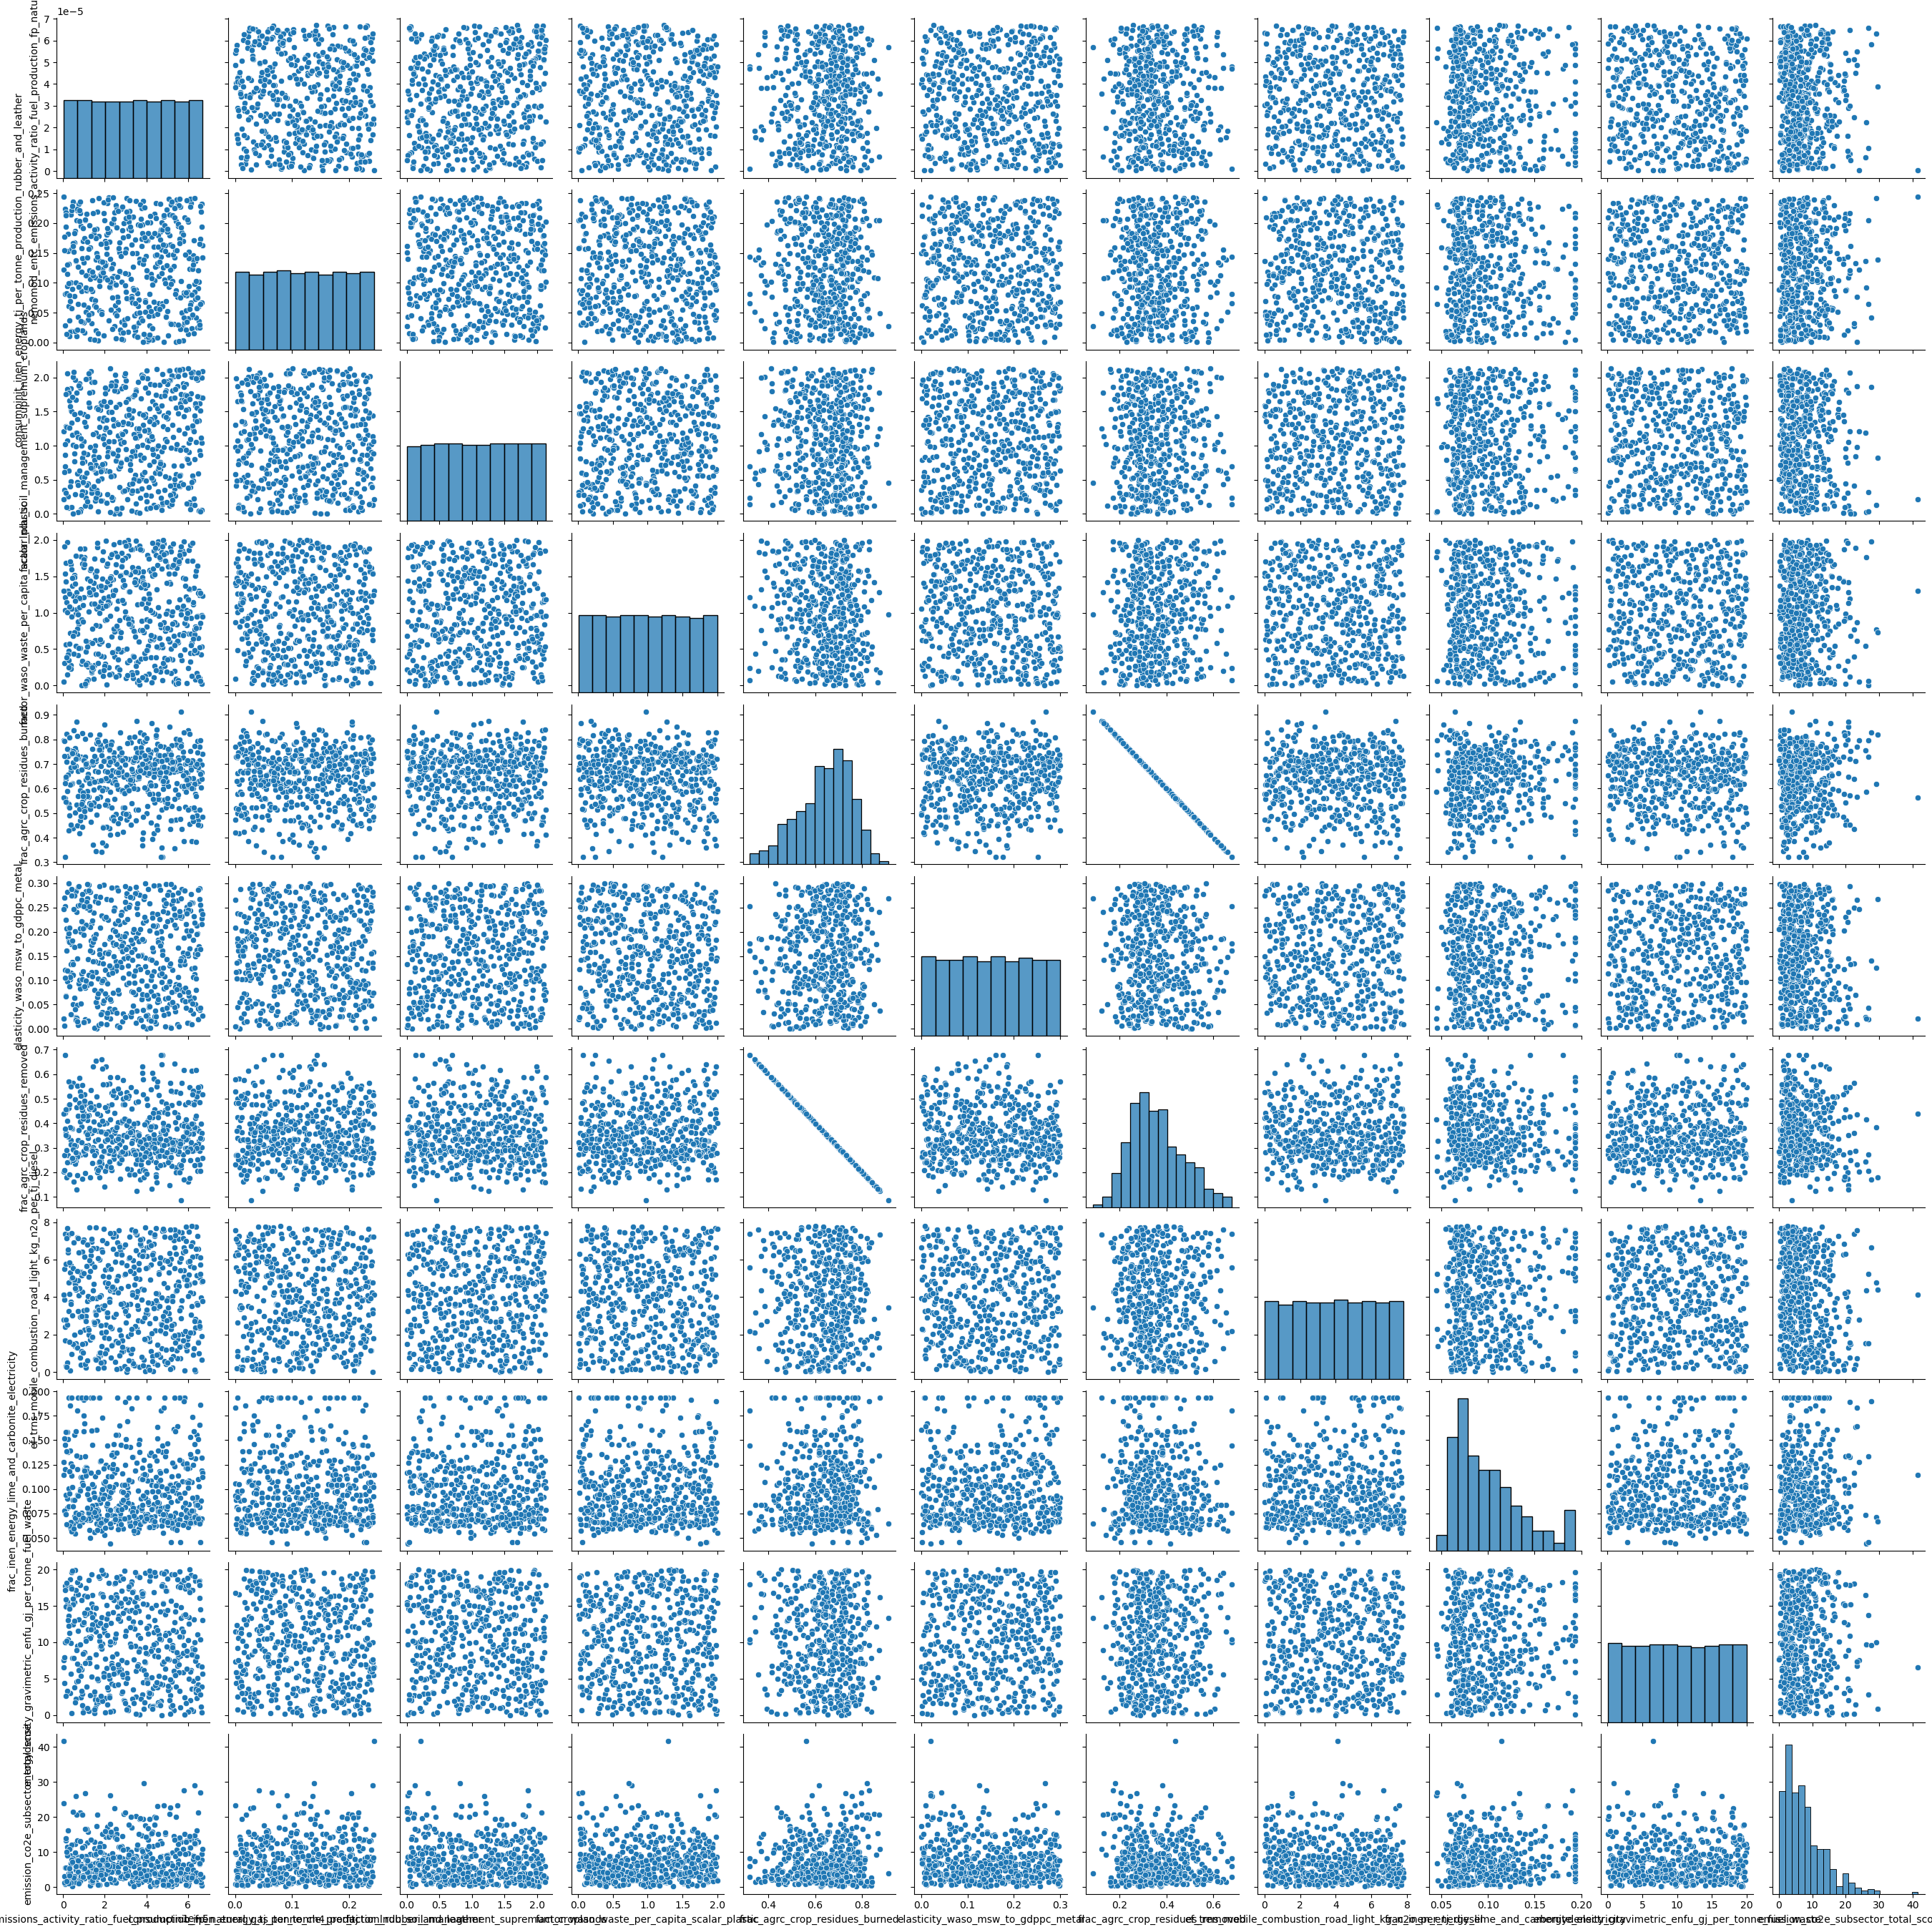

In [58]:
import seaborn as sns

sns.pairplot(important_df)


In [59]:
corr = important_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,nemomod_entc_emissions_activity_ratio_fuel_production_fp_natural_gas_tonne_ch4_per_tj,consumpinit_inen_energy_tj_per_tonne_production_rubber_and_leather,factor_lndu_soil_management_supremum_croplands,factor_waso_waste_per_capita_scalar_plastic,frac_agrc_crop_residues_burned,elasticity_waso_msw_to_gdppc_metal,frac_agrc_crop_residues_removed,ef_trns_mobile_combustion_road_light_kg_n2o_per_tj_diesel,frac_inen_energy_lime_and_carbonite_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_waste,emission_co2e_subsector_total_scoe
nemomod_entc_emissions_activity_ratio_fuel_production_fp_natural_gas_tonne_ch4_per_tj,1.000000,-0.036978,0.109006,0.008494,0.012390,-0.017589,-0.012390,0.024399,-0.044034,-0.058508,-0.019614
consumpinit_inen_energy_tj_per_tonne_production_rubber_and_leather,-0.036978,1.000000,-0.025244,-0.015225,0.021102,-0.046088,-0.021102,-0.033896,-0.014592,-0.035569,0.033849
factor_lndu_soil_management_supremum_croplands,0.109006,-0.025244,1.000000,0.043799,0.003702,0.041865,-0.003702,0.024300,0.045472,-0.059368,-0.099101
factor_waso_waste_per_capita_scalar_plastic,0.008494,-0.015225,0.043799,1.000000,-0.076593,-0.093143,0.076593,-0.035633,-0.042559,-0.010901,-0.000656
frac_agrc_crop_residues_burned,0.012390,0.021102,0.003702,-0.076593,1.000000,0.047305,-1.000000,-0.000877,0.042276,-0.033177,0.062557
elasticity_waso_msw_to_gdppc_metal,-0.017589,-0.046088,0.041865,-0.093143,0.047305,1.000000,-0.047305,0.035015,0.073630,0.067816,-0.109280
frac_agrc_crop_residues_removed,-0.012390,-0.021102,-0.003702,0.076593,-1.000000,-0.047305,1.000000,0.000877,-0.042276,0.033177,-0.062557
ef_trns_mobile_combustion_road_light_kg_n2o_per_tj_diesel,0.024399,-0.033896,0.024300,-0.035633,-0.000877,0.035015,0.000877,1.000000,0.043471,-0.010646,-0.137910
frac_inen_energy_lime_and_carbonite_electricity,-0.044034,-0.014592,0.045472,-0.042559,0.042276,0.073630,-0.042276,0.043471,1.000000,0.012495,0.084745
energydensity_gravimetric_enfu_gj_per_tonne_fuel_waste,-0.058508,-0.035569,-0.059368,-0.010901,-0.033177,0.067816,0.033177,-0.010646,0.012495,1.000000,-0.015392


In [84]:
important_df.var()

demscalar_ippu_plastic                                                                 3.344483e-01
nemomod_entc_output_activity_ratio_fuel_production_fp_petroleum_refinement_gasoline    7.686331e-02
nemomod_entc_capital_cost_pp_wind_mm_usd_per_gw                                        2.181903e+06
ratio_agrc_below_ground_to_above_ground_biomass_other_annual                           7.224046e-03
deminit_frst_wood_home_use_kg_per_hh                                                   9.297793e+04
ef_enfu_combustion_tonne_co2_per_tj_fuel_natural_gas                                   1.215736e+03
ef_waso_incineration_tonne_n2o_per_tonne_rubber_leather                                2.528041e-09
energydensity_gravimetric_enfu_gj_per_tonne_fuel_coal                                  1.950788e+02
efficfactor_enfu_industrial_energy_fuel_diesel                                         1.882453e-01
efficfactor_scoe_heat_energy_residential_hydrocarbon_gas_liquids                       1.886543e-01


#